In [192]:
import matplotlib.pyplot as plt  
import numpy as np
import cv2
import pickle
import imutils
import gzip
import tkinter as tk
from tkinter import * 
from PIL import ImageTk, Image
from tkinter import messagebox


In [193]:
#Interface

In [194]:
#TRAINING THE MODEL

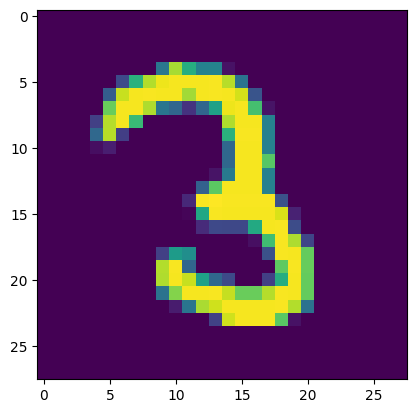

In [195]:
with open('mini-mnist-1000.pickle', 'rb') as f:
    data = pickle.load(f)

y=data['labels']
x=data['images']

plt.imshow(x[320])

In [196]:
winSize = (4, 4)
blockSize = (4, 4)
blockStride = (4, 4)
cellSize = (4, 4)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
winStride = (4, 4)
padding = (4, 4)
locations = ((10, 20),)
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
X=[]
for i in range(1000):
    X.append(hog.compute(x[i],winStride,padding,locations))

In [197]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 50, max_depth=None, min_samples_split=2, random_state=0)

classifier.fit(X,y)

print(classifier.score(X,y)) #accuracy percentage


0.909


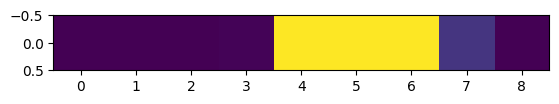

In [198]:
# predict the labels
classifier.predict([X[320]]) #predicting labels of all images
plt.imshow([X[320]])

In [199]:
#USING THE IMAGE TO FIND THE GRID

In [200]:
def resultcorrect():
    messagebox.showinfo("Correct","Congrats! Your sudoku is correct.")

In [201]:
def resultincorrect():
    messagebox.showerror("Incorrect","Your sudoku is incorrect.")

In [202]:
def check(sudoku): #Sudoku Solving
    check1=False
    for i in range(9):
        for j in range(9):
            for k in range(9): #for columns
                if sudoku[i][j]==sudoku[i][k]:
                    check1=True
    check2=False
    for i in range(9):
        for j in range(9):
            for k in range(9): #for rows
                if sudoku[i][j]==sudoku[k][j]:
                    check2=True

    if(check1==True or check2== True):
        resultincorrect()
    else:
        resultcorrect()    

In [203]:
def findsudoku(finalimg):
    row,col,ch=finalimg.shape
    finalimg = cv2.cvtColor(finalimg, cv2.COLOR_BGR2GRAY)
    finalimg = cv2.GaussianBlur(finalimg, (5, 5), 1) 
    finalimg=cv2.adaptiveThreshold(finalimg, 255, 1, 1, 11, 2) 
    number=np.zeros((int(row/9),int(col/9)),dtype=np.uint8)
    r=int(row/9)
    c=int(col/9)
    hist=[]
    k=0
    sudoku=np.zeros((9,9),dtype=np.uint8)
    for i in range(9):
        for j in range(9):
            number=finalimg[5+r*i:r*(i+1),5+c*j:c*(j+1)]
            hist.append(hog.compute(number,winStride,padding,locations))
            sudoku[i][j]=classifier.predict([hist[k]])
            k=k+1

    check(sudoku)        


In [204]:
def perspective(img, location, rows = 450, cols = 450):
    point1 = np.array([location[0], location[3], location[1], location[2]],dtype=np.float32)
    point2 = np.array([[0, 0], [cols, 0], [0, rows], [cols, rows]],dtype=np.float32)
    grid = cv2.getPerspectiveTransform(point1, point2)
    finalimg = cv2.warpPerspective(img, grid, (cols, rows))
    return finalimg

In [205]:
def findcontour(imglocation):
    img = cv2.imread(imglocation)
    imggray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgblur = cv2.GaussianBlur(imggray, (5, 5), 1) 
    imgthresh = cv2.adaptiveThreshold(imgblur, 255, 1, 1, 11, 2) 
    contour = cv2.findContours(imgthresh.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    contour = imutils.grab_contours(contour)
    sortedcontours = sorted(contour, key=cv2.contourArea, reverse=True)



    location = None
    # Finds rectangular contour
    for contour in sortedcontours:
        approxpoly = cv2.approxPolyDP(contour, 15, True)
        if len(approxpoly) == 4:
            location = approxpoly
        break
    finalimg = perspective(img, location)
    plt.imshow(finalimg)
    findsudoku(finalimg)


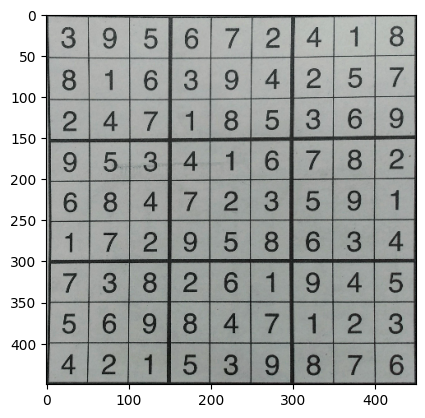

In [206]:
root = Tk()
root.geometry("1000x666")
root.minsize(1000,666)
imglocation =" "

#button functions
def getimage():
    imglocation = imgpathbox.get() #imglocation is the variable where the thing ends up being stored
    findcontour(imglocation)


#creating objects
bgpic = ImageTk.PhotoImage(file= "sudoku.png", master = root)

#creating bg canvas
canvas = Canvas(root, width = 1000, height = 666)
canvas.pack(fill = "both", expand = True)

#displaying bg
canvas.create_image(0,0,image=bgpic,anchor = "nw")

#creating fg objects
label1 = Label(root, text="Sudoku checker", font=("Hellvetica",40))
enterbutton = Button(root, text="Enter", font= ("Hellvetica", 14), command = getimage, padx = 10, pady = 3)
imgpathbox = Entry(root, width = 60, font=("Hellvetica", 20))
imgpathbox.insert(0, "Enter image filename")
imgpathbox.config( fg='#d7d7d9')

#displaying fg elements
label1_win = canvas.create_window(320, 120, anchor="nw", window = label1)
enterbutton_win = canvas.create_window(470, 590, anchor="nw", window = enterbutton)
imgpathbox_win = canvas.create_window(40, 320, anchor="nw", window = imgpathbox)



root.mainloop()
